## <center>Проверка системы сплитования пользователей
В лекции мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк! Мы будем многократно извлекать подвыборки из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, что нужно сделать: у нас есть данные АА-теста с '2022-12-25' по '2022-12-31'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [2]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
from scipy import stats

In [3]:
connection = {'host':'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20230120',
             'user':'student',
             'password':'dpo_python_2020'
             }

In [4]:
query = '''
select exp_group, 
    user_id, 
    sum(action = 'like') likes,
    sum(action = 'view') views,
    likes/views ctr
from {db}.feed_actions 
where toDate(time) between '2022-12-25' and '2022-12-31'
    and exp_group in (2,3)
group by exp_group, user_id 
'''

In [5]:
df = ph.read_clickhouse(query, connection=connection)

In [6]:
df.shape

(17049, 5)

In [78]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [79]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Количество пользователей в группах +- одинаковое.

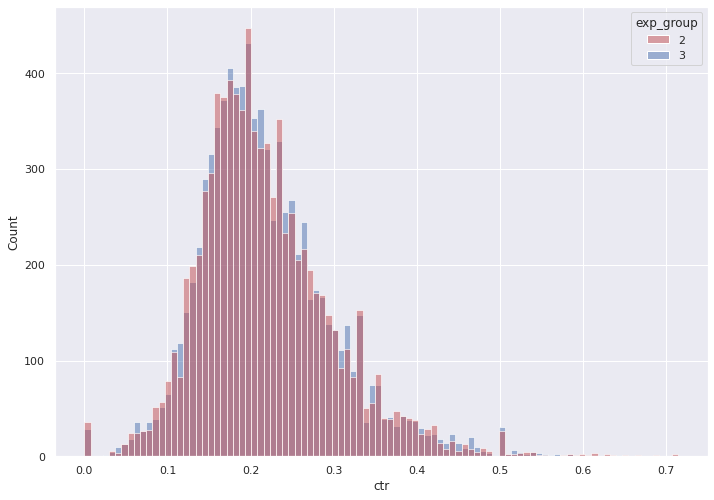

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.histplot(data = df,
             x='ctr',
             hue='exp_group',
             palette = ['r', 'b'])

Визуально тестовая и контрольная группа похожи, распределение в обеих группах отдаленно напоминает нормальное, но имеющее длинный хвост справа, слегка скошено влево и небольшое количество выбросов.

**Выполним t-test Стьюдента:**   

- Нулевая гипотеза: $H_0: \mu_1=\mu_2$
 

- Альтернативная гипотеза $H_0: \mu_1\neq\mu_2$ 


In [11]:
stats.ttest_ind(df[df['exp_group']==2].ctr, 
                df[df['exp_group']==3].ctr, 
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

Результат p-value ~ 0.46, это очень много, вероятность ошибки первого рода очень велика. Потдверждается нулевая теория о равенстве средних, различия в выборках статистически незначимы.

**Выполним U test Манна-Уитни:**   
- Нулевая гипотеза $H_0: P(X>Y) = P(Y>X)$

- Альтернативная гипотеза $H_1: P(X>Y) \not= P(Y>X)$


In [12]:
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr)

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)

По результатам теста Манна-Уитни можем принять $H_0$. Различия в выборках статистически незначимы.


**Симуляция 10000 АА-тестов со случайными подвыборками без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проведение для этих подвыборок t теста.**

In [13]:
p_vals = []
for i in range(10000):
    a = df[df['exp_group']==2].ctr.sample(500, replace=False)
    b = df[df['exp_group']==3].ctr.sample(500, replace=False)
    p_vals.append(stats.ttest_ind(a, b, equal_var=False)[1])

Построим гистограмму распределения получившихся 10000 p-values.

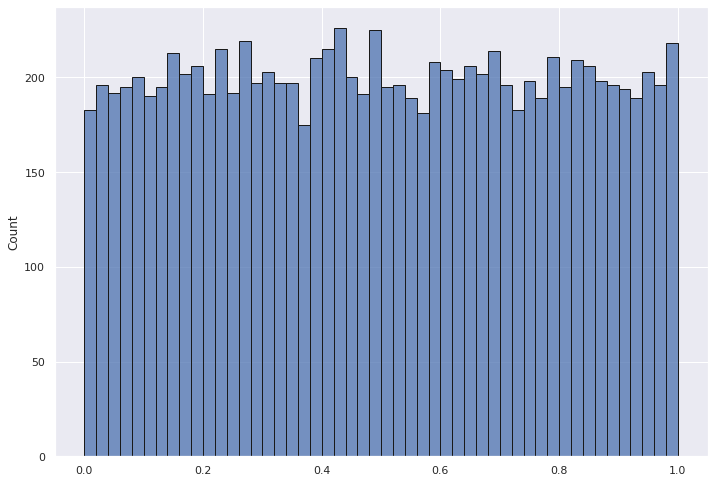

In [25]:
gr = sns.histplot(p_vals, 
                  bins = 50, 
                  edgecolor = "0.1")

P-value распределены приблизительно равномерно.

In [19]:
# считаем длину отфильтрованного списка с значениями p values <= 0.05
n = len(list(filter(lambda i: i <= 0.05, p_vals)))

In [20]:
print(f"{n / len(p_vals) * 100}% p values оказались меньше либо равны 0.05.")

4.6899999999999995% p values оказались меньше либо равны 0.05.


## Вывод

Система сплитования работает корректно, наш AA тест сходится - можем начинать AB тестирование на группах 2 и 3.   
Более того, из 1000 итераций t теста для двух случайных подвыборок **без повторения** в 500 юзеров из 2 и 3 экспериментальной группы всего в 4.74% случаев значение p-value оказалось ниже или равно 0.05, что ниже уровня значимости в 5%. На основе этого можно сделать вывод, что подвыборка в 500 случайных юзеров с вероятностью 95,26% будет содержать все признаки генеральной совокупности выборки в 8600 юзеров и тем самым при текущей системе сплитования, мы можем уверенно тестировать новый функционал на значительно более малых выборках. Это позволит нам в реальных условиях снизить ризки внедрения неоптимального функционала и позоволит ускорить время проведения AB теста.